In [1]:
!pip install finterstellar

In [ ]:
!pip install joblib tqdm

In [3]:
# Import library
import finterstellar as fs
#System trading Library 설치: Finterstellar

import io, sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
symbol_ = 'TSLA'
start_date_ = '2020-06-30'
end_date_ = '2025-06-30'
fee_ = 0.001

In [5]:
path_list = ["rsi","macd","stochastic"]

for path in path_list :
    try:
        os.makedirs(path, exist_ok=True)
        print(f"{path} 디렉토리가 생성되었거나 이미 존재합니다.")
    except OSError as e:
        print(f"디렉토리 생성 중 오류 발생: {e}")


rsi 디렉토리가 생성되었거나 이미 존재합니다.
macd 디렉토리가 생성되었거나 이미 존재합니다.
stochastic 디렉토리가 생성되었거나 이미 존재합니다.


In [6]:
# Performance 문자열을 Parsing 하여 반환하는 함수
def parse_performance_output(output_text):
    result = {}
    for line in output_text.strip().split("\n"):
        # 콜론으로 분리
        if ":" not in line:
            continue
        key, value = line.split(":", 1)
        key = key.strip()
        value = value.strip()

        # 퍼센트 처리
        if value.endswith("%"):
            num = float(value.strip("%")) / 100
            result[key] = num
        # 연도 처리
        elif value.endswith("yrs"):
            num = float(value.strip("yrs"))
            result[key] = num
        # 숫자 처리
        else:
            try:
                result[key] = float(value)
            except ValueError:
                result[key] = value  # 혹시 문자열이면 그대로 저장

    return result

In [7]:
# 1. RSI Performance and evaluation

In [8]:
# RSI 를 구해서 dict 를 반환하는 함수
def get_rsi_performance_dict(symbol_, df, params) :
    w_, buy_, sell_, fee_ = params

    # dataFrame 초기화
    df_tmp = df.copy()

    result_dict = {}

    # 파라미터 추가
    result_dict["symbol"] = symbol_
    result_dict["w_param"] = w_
    result_dict["buy_param"] = buy_
    result_dict["sell_param"] = sell_
    result_dict["fee_"] = fee_

    perf = {}

    # RSI 계산, indicator signal 도출, position 계산, 평가 및 performance 측정
    fs.rsi(df_tmp, w=w_)
    fs.indicator_to_signal(df_tmp, factor='rsi', buy=buy_, sell=sell_)
    fs.position(df_tmp)
    fs.evaluate(df_tmp, cost= fee_)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # Performance 함수 실행 (print만 함)
        fs.performance(df_tmp, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    perf = parse_performance_output(output_text)

    result_dict.update(perf)

    print(f"Performance Processing : {result_dict}")

    return result_dict

In [ ]:
# MACD 를 구해서 dict 를 반환하는 함수
def get_macd_performance_dict(symbol_, df, params) :
    buy_, sell_, fee_ = params

    # dataFrame 초기화
    df_tmp = df.copy()

    result_dict = {}

    # 파라미터 추가
    result_dict["symbol"] = symbol_
    result_dict["buy_param"] = buy_
    result_dict["sell_param"] = sell_
    result_dict["fee_"] = fee_

    perf = {}

    # MACD 계산, indicator signal 도출, position 계산, 평가 및 performance 측정
    fs.macd(df_tmp)
    fs.indicator_to_signal(df_tmp, factor='macd', buy=buy_, sell=sell_)
    fs.position(df_tmp)
    fs.evaluate(df_tmp, cost= fee_)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # Performance 함수 실행 (print만 함)
        fs.performance(df_tmp, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    perf = parse_performance_output(output_text)

    result_dict.update(perf)

    print(f"Performance Processing : {result_dict}")

    return result_dict

In [10]:
# Stochastic 를 구해서 dict 를 반환하는 함수
def get_stochastic_performance_dict(symbol_, df, params) :
    factor_, buy_, sell_, fee_ = params

    # dataFrame 초기화
    df_tmp = df.copy()

    result_dict = {}

    # 파라미터 추가
    result_dict["symbol"] = symbol_
    result_dict["factor"] = factor_
    result_dict["buy_param"] = buy_
    result_dict["sell_param"] = sell_
    result_dict["fee_"] = fee_

    perf = {}

    # Stochastic 계산, indicator signal 도출, position 계산, 평가 및 performance 측정
    fs.stochastic(df_tmp, symbol_, n=14, m=3, t=3)
    # indicator 값 추출을 위한 전처리 작업
    df_tmp['indicator'] = df_tmp['slow_k'] - df_tmp['slow_d']

    fs.indicator_to_signal(df_tmp, factor= factor_, buy=buy_, sell=sell_)
    fs.position(df_tmp)
    fs.evaluate(df_tmp, cost= fee_)

    # print 값 변수화
    capture = io.StringIO()
    # stdout 백업
    old_stdout = sys.stdout

    try:
        # stdout을 StringIO로 바꿈
        sys.stdout = capture

        # Performance 함수 실행 (print만 함)
        fs.performance(df_tmp, rf_rate=0.02)

    finally:
        # stdout 복원
        sys.stdout = old_stdout

    # 캡처된 텍스트
    output_text = capture.getvalue()
    # performance dict 화
    # performance_dict = parse_performance_output(output_text)
    perf = parse_performance_output(output_text)

    result_dict.update(perf)

    print(f"Performance Processing : {result_dict}")


    return result_dict

In [11]:
# 모든 팩터 집합을 이용해 최적의 RSI Parameter 계산
# Parallel 을 이용해서 성능 개선
from joblib import Parallel, delayed
from tqdm import tqdm

def get_rsi_performance_dataframe(symbol, start_date_, end_date_, fee_) :

    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    # df = pd.read_csv(f"get_price_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    # Parameter 집합 도출(list)
    w_range = range(7,23+1)
    buy_range = range(15,45+1)
    sell_range = range(55,85+1)
    param_list = [(w,buy,sell,fee_) for w in w_range for buy in buy_range for sell in sell_range]

    results = []

    # 최적의 w, buy_position, sell_position 을 찾기 위한 recursive
    # For문 이용
    # for w in range(7,23+1)
    #   for buy in range(15, 45+1)
    #       for sell in range(55,85+1)
    #           results.append(get_rsi_performance_dict(df,w,buy,sell,fee_))

    # Parallel 이용
    results = Parallel(n_jobs=-1, verbose=10, batch_size=100) (
            delayed(get_rsi_performance_dict)(symbol, df, params) for params in tqdm(param_list)
    )

    df_result = pd.DataFrame(results)
    return df_result

In [12]:
# 모든 팩터 집합을 이용해 최적의 MACD Parameter 계산
# Parallel 을 이용해서 성능 개선

def get_macd_performance_dataframe(symbol, start_date_, end_date_, fee_) :

    df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    # df = pd.read_csv(f"get_price_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    # Parameter 집합 도출(list)
    buy_range = range(-10,10+1)
    sell_range = range(-10,10+1)
    param_list = [(buy,sell,fee_) for buy in buy_range for sell in sell_range]

    results = []

    # 최적의 buy_position, sell_position 을 찾기 위한 recursive
    # For문 이용
    # for buy in range(-10,10+1)
    #    for sell in range(-10,10+1)
    #        results.append(get_macd_performance_dict(df,buy,sell,fee_))

    # Parallel 이용
    results = Parallel(n_jobs=-1, verbose=10, batch_size=50) (
            delayed(get_macd_performance_dict)(symbol, df, params) for params in tqdm(param_list)

    )

    df_result = pd.DataFrame(results)
    return df_result

In [13]:
# 모든 팩터 집합을 이용해 최적의 Stochastic Parameter 계산
# Parallel 을 이용해서 성능 개선

def get_stochastic_performance_dataframe(symbol, start_date_, end_date_, fee_) :

    df = fs.get_ohlc(symbol, start_date=start_date_, end_date=end_date_)
    # df = pd.read_csv(f"get_ohlc_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    print(f"[ {symbol} ] dataFrame.head ")
    print(df.head(3))

    # Parameter 집합 도출(list)
    factor_list = ['slow_k','indicator']
    buy_range = range(10,40+1)
    sell_range = range(60,90+1)
    param_list = [(factor_,buy,sell,fee_) for factor_ in factor_list for buy in buy_range for sell in sell_range]

    results = []

    # 최적의 buy_position, sell_position 을 찾기 위한 recursive
    # For문 이용
    # for factor in factor_list
    #   for buy in range(10, 40+1)
    #       for sell in range(60,90+1)
    #           results.append(get_stochastics_performance_dict(factor,buy,sell,fee_))

    # Parallel 이용
    results = Parallel(n_jobs=-1, verbose=10, batch_size=50) (
            delayed(get_stochastic_performance_dict)(symbol, df, params) for params in tqdm(param_list)
    )

    df_result = pd.DataFrame(results)
    return df_result

In [14]:
symbol_list = ['^GSPC', '^KS11','MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'AAPL']

In [19]:
# Parameter 조합을 csv 로 저장
for symbol in symbol_list :
    df_rsi = get_rsi_performance_dataframe(symbol, start_date_, end_date_, fee_)
    df_macd = get_macd_performance_dataframe(symbol, start_date_, end_date_, fee_)
    df_sto = get_stochastic_performance_dataframe(symbol, start_date_, end_date_, fee_)

    # write csv
    df_rsi.to_csv(f'./rsi/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)
    df_macd.to_csv(f'./macd/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)
    df_sto.to_csv(f'./stochastic/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8', index=False)

[ ^GSPC ] dataFrame.head 
              ^GSPC
2020-06-30 3,100.29
2020-07-01 3,115.86
2020-07-02 3,130.01


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
  0%|          | 24/16337 [00:10<1:56:11,  2.34it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.5min
 22%|██▏       | 3624/16337 [10:04<34:56,  6.06it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 13.4min
100%|██████████| 16337/16337 [42:52<00:00,  6.35it/s]
[Parallel(n_jobs=-1)]: Done 14964 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 15734 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 

[ ^GSPC ] dataFrame.head 
              ^GSPC
2020-06-30 3,100.29
2020-07-01 3,115.86
2020-07-02 3,130.01


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 7977.54it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Don

[ ^GSPC ] dataFrame.head 
               Open     High      Low    Close      Volume  Adj Close
2020-06-30 3,050.20 3,111.51 3,047.83 3,100.29  4705850000   3,100.29
2020-07-01 3,105.92 3,128.44 3,101.17 3,115.86  4449230000   3,115.86
2020-07-02 3,143.64 3,165.81 3,124.52 3,130.01  4197720000   3,130.01


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s
100%|██████████| 1922/1922 [00:04<00:00, 429.01it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1702 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1843 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    4.8s finished


[ ^KS11 ] dataFrame.head 
              ^KS11
2020-06-30 2,108.33
2020-07-01 2,106.70
2020-07-02 2,135.37


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
  0%|          | 24/16337 [00:03<42:08,  6.45it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.1min
 22%|██▏       | 3624/16337 [09:10<32:04,  6.60it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 12.2min
100%|██████████| 16337/16337 [41:47<00:00,  6.52it/s]
[Parallel(n_jobs=-1)]: Done 15059 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 15734 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 16

[ ^KS11 ] dataFrame.head 
              ^KS11
2020-06-30 2,108.33
2020-07-01 2,106.70
2020-07-02 2,135.37


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 7701.93it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Don

[ ^KS11 ] dataFrame.head 
               Open     High      Low    Close   Volume  Adj Close
2020-06-30 2,124.38 2,134.38 2,108.26 2,108.33   708600   2,108.33
2020-07-01 2,128.81 2,133.55 2,101.33 2,106.70  1116200   2,106.70
2020-07-02 2,116.72 2,135.37 2,113.98 2,135.37  1092000   2,135.37


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
100%|██████████| 1922/1922 [00:04<00:00, 444.24it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1444 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1555 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1568 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1583 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.2s finished


[ MSFT ] dataFrame.head 
             MSFT
2020-06-30 194.98
2020-07-01 196.12
2020-07-02 197.61


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
  0%|          | 24/16337 [00:03<40:07,  6.77it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
 22%|██▏       | 3624/16337 [09:34<33:44,  6.28it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 12.7min
100%|██████████| 16337/16337 [42:01<00:00,  6.48it/s]
[Parallel(n_jobs=-1)]: Done 14964 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 15259 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 15364 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 15764 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 16

[ MSFT ] dataFrame.head 
             MSFT
2020-06-30 194.98
2020-07-01 196.12
2020-07-02 197.61


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 8667.46it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Don

[ MSFT ] dataFrame.head 
             Open   High    Low  Close    Volume  Adj Close
2020-06-30 197.88 204.40 197.74 203.51  34310300     194.98
2020-07-01 203.14 206.35 201.77 204.70  32061200     196.12
2020-07-02 205.68 208.02 205.00 206.26  29315800     197.61


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
100%|██████████| 1922/1922 [00:04<00:00, 442.54it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1395 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1555 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1568 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1583 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1615 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.6s finished


[ GOOG ] dataFrame.head 
            GOOG
2020-06-30 70.26
2020-07-01 71.48
2020-07-02 72.80


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
  0%|          | 24/16337 [00:03<43:08,  6.30it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
 22%|██▏       | 3624/16337 [09:38<33:55,  6.24it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 12.8min
100%|██████████| 16337/16337 [43:23<00:00,  6.27it/s]
[Parallel(n_jobs=-1)]: Done 15059 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 15439 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 15829 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 16

[ GOOG ] dataFrame.head 
            GOOG
2020-06-30 70.26
2020-07-01 71.48
2020-07-02 72.80


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 8641.95it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Don

[ GOOG ] dataFrame.head 
            Open  High   Low  Close    Volume  Adj Close
2020-06-30 69.52 70.93 69.20  70.68  40848000      70.26
2020-07-01 70.56 72.15 70.49  71.90  35504000      71.48
2020-07-02 72.35 74.15 72.32  73.24  37182000      72.80


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s
100%|██████████| 1922/1922 [00:04<00:00, 420.00it/s]
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1542 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1647 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.3s finished


[ AMZN ] dataFrame.head 
             AMZN
2020-06-30 137.94
2020-07-01 143.93
2020-07-02 144.51


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
  0%|          | 24/16337 [00:03<40:10,  6.77it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
 22%|██▏       | 3624/16337 [09:36<33:47,  6.27it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 12.8min
100%|██████████| 16337/16337 [42:51<00:00,  6.35it/s]
[Parallel(n_jobs=-1)]: Done 14964 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 15639 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 16

[ AMZN ] dataFrame.head 
             AMZN
2020-06-30 137.94
2020-07-01 143.93
2020-07-02 144.51


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 9116.70it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Don

[ AMZN ] dataFrame.head 
             Open   High    Low  Close     Volume  Adj Close
2020-06-30 134.25 138.48 133.75 137.94   75394000     137.94
2020-07-01 137.90 144.75 137.70 143.93  127268000     143.93
2020-07-02 145.60 147.78 143.55 144.51  131868000     144.51


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
100%|██████████| 1922/1922 [00:04<00:00, 412.52it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1395 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1457 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1519 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.6s finished


[ META ] dataFrame.head 
             META
2020-06-30 225.83
2020-07-01 236.25
2020-07-02 232.15


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
  0%|          | 24/16337 [00:03<40:49,  6.66it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
 22%|██▏       | 3624/16337 [09:41<34:03,  6.22it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 12.9min
100%|██████████| 16337/16337 [43:28<00:00,  6.26it/s]
[Parallel(n_jobs=-1)]: Done 14964 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 15544 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 16

[ META ] dataFrame.head 
             META
2020-06-30 225.83
2020-07-01 236.25
2020-07-02 232.15


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 8133.11it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Don

[ META ] dataFrame.head 
             Open   High    Low  Close    Volume  Adj Close
2020-06-30 220.59 227.50 218.47 227.07  33927100     225.83
2020-07-01 228.50 239.00 227.56 237.55  43399700     236.25
2020-07-02 239.00 240.00 232.61 233.42  30633600     232.15


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s
100%|██████████| 1922/1922 [00:04<00:00, 423.58it/s]
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1433 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1493 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1794 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    4.9s finished


[ NVDA ] dataFrame.head 
            NVDA
2020-06-30  9.47
2020-07-01  9.50
2020-07-02  9.58


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
  0%|          | 24/16337 [00:03<42:30,  6.40it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.3min
 22%|██▏       | 3624/16337 [09:52<34:36,  6.12it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 13.2min
100%|██████████| 16337/16337 [42:43<00:00,  6.37it/s]
[Parallel(n_jobs=-1)]: Done 14964 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 15449 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 16

[ NVDA ] dataFrame.head 
            NVDA
2020-06-30  9.47
2020-07-01  9.50
2020-07-02  9.58


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 9042.45it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Don

[ NVDA ] dataFrame.head 
            Open  High  Low  Close     Volume  Adj Close
2020-06-30  9.31  9.53 9.27   9.50  367892000       9.47
2020-07-01  9.52  9.58 9.41   9.53  326648000       9.50
2020-07-02  9.64  9.74 9.58   9.61  364056000       9.58


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s
100%|██████████| 1922/1922 [00:04<00:00, 435.65it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1493 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1506 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1519 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1534 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1549 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1615 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.4s finished


[ TSLA ] dataFrame.head 
            TSLA
2020-06-30 71.99
2020-07-01 74.64
2020-07-02 80.58


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
  0%|          | 24/16337 [00:03<42:16,  6.43it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.3min
 22%|██▏       | 3624/16337 [09:42<34:04,  6.22it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 13.0min
100%|██████████| 16337/16337 [41:43<00:00,  6.52it/s]
[Parallel(n_jobs=-1)]: Done 15059 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 15259 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 15364 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 15479 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 15974 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 16

[ TSLA ] dataFrame.head 
            TSLA
2020-06-30 71.99
2020-07-01 74.64
2020-07-02 80.58


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 8466.83it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Don

[ TSLA ] dataFrame.head 
            Open  High   Low  Close     Volume  Adj Close
2020-06-30 67.10 72.51 66.92  71.99  253777500      71.99
2020-07-01 72.20 75.69 72.03  74.64  199903500      74.64
2020-07-02 81.43 81.87 79.04  80.58  258751500      80.58


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
100%|██████████| 1922/1922 [00:04<00:00, 416.76it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1433 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1493 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1555 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1892 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    5.0s finished


[ AAPL ] dataFrame.head 
            AAPL
2020-06-30 88.65
2020-07-01 88.49
2020-07-02 88.49


  0%|          | 0/16337 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
  0%|          | 24/16337 [00:03<43:03,  6.31it/s][Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.3min
 22%|██▏       | 3624/16337 [09:41<34:01,  6.23it/s][Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3724 tasks      | elapsed: 13.0min
100%|██████████| 16337/16337 [41:49<00:00,  6.51it/s]
[Parallel(n_jobs=-1)]: Done 15059 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 15154 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 15734 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 15934 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 16049 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 16164 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 16

[ AAPL ] dataFrame.head 
            AAPL
2020-06-30 88.65
2020-07-01 88.49
2020-07-02 88.49


  0%|          | 0/441 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
100%|██████████| 441/441 [00:00<00:00, 8771.12it/s]
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Don

[ AAPL ] dataFrame.head 
            Open  High   Low  Close     Volume  Adj Close
2020-06-30 90.02 91.50 90.00  91.20  140223200      88.65
2020-07-01 91.28 91.84 90.98  91.03  110737200      88.49
2020-07-02 91.96 92.62 90.91  91.03  114041600      88.49


  0%|          | 0/1922 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
100%|██████████| 1922/1922 [00:04<00:00, 432.60it/s]
[Parallel(n_jobs=-1)]: Done 1275 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1433 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1715 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1828 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1843 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1922 out of 1922 | elapsed:    4.8s finished


In [ ]:
# Read_csv
# Max CAGR, Max Sharpe Ratio 값 구하기
# 해당 값에 해당하는 performance 값 계산 후 image 출력

In [31]:
# Max Parameter 를 이용하여 chart Graph 도출
def get_rsi_max_performance(symbol, start_date_, end_date_, fee_, text) :
    df_rsi = pd.read_csv(f'./rsi/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8')

    max_series = df_rsi[df_rsi[text] == df_rsi[text].max()].iloc[0]
    max_w = max_series['w_param']
    max_buy = max_series['buy_param']
    max_sell = max_series['sell_param']

    print(f"### {symbol}'s Parameter of max({text})")
    print(f"{max_series}")

    # df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    df = pd.read_csv(f"get_price_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    # rsi
    fs.rsi(df, w=max_w)
    fs.draw_chart(df, left='rsi', right= symbol)
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor='rsi', buy=max_buy, sell=max_sell)
    # Calc position
    fs.position(df)
    fs.draw_chart(df, left='rsi', right='position_chart')
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    # Evalution
    fs.evaluate(df, cost= fee_)
    fs.draw_chart(df, left='acc_rtn_dp', right=symbol)
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_evaluation_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    # get Performance
    fs.performance(df, rf_rate=0.02)

    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./rsi/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    return max_series

In [32]:
# Max Parameter 를 이용하여 chart Graph 도출
def get_macd_max_performance(symbol, start_date_, end_date_, fee_, text) :
    df_macd = pd.read_csv(f'./macd/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8')

    max_series = df_macd[df_macd[text] == df_macd[text].max()].iloc[0]
    max_buy = max_series['buy_param']
    max_sell = max_series['sell_param']

    print(f"### {symbol}'s Parameter of max({text})")
    print(f"{max_series}")

    # df = fs.get_price(symbol, start_date=start_date_, end_date=end_date_)
    df = pd.read_csv(f"get_price_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    # macd
    fs.macd(df)
    fs.draw_chart(df, right=['macd','macd_signal','macd_oscillator'])
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor='macd_oscillator', buy=max_buy, sell=max_sell)

    # Calc position
    fs.position(df)
    fs.draw_chart(df, right='position_chart', left='macd_oscillator')
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()


    # Evalution
    fs.evaluate(df, cost=fee_)
    fs.performance(df, rf_rate=0.02)
    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./macd/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()
    
    return max_series

In [33]:
# Max Parameter 를 이용하여 chart Graph 도출
def get_stochastic_max_performance(symbol, start_date_, end_date_, fee_, text) :
    df_sto = pd.read_csv(f'./stochastic/{symbol}_{start_date_}_to_{end_date_}.csv',encoding='utf8')

    max_series = df_sto[df_sto[text] == df_sto[text].max()].iloc[0]
    max_factor = max_series['factor']
    max_buy = max_series['buy_param']
    max_sell = max_series['sell_param']

    print(f"### {symbol}'s Parameter of max({text})")
    print(f"{max_series}")

    # df = fs.get_ohlc(symbol, start_date=start_date_, end_date=end_date_)
    df = pd.read_csv(f"get_ohlc_{symbol}_{start_date_}_to_{end_date_}.csv", encoding="utf8", index_col=0, parse_dates=True)

    # stochastic
    fs.stochastic(df, symbol, n=14, m=3, t=3)
    df['indicator'] = df['slow_k'] - df['slow_d']
    fs.draw_chart(df, left=max_factor, right=symbol)
    # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_price_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()

    fs.indicator_to_signal(df, factor=max_factor, buy=max_buy, sell=max_sell)

    # Calc position
    fs.position(df)
    fs.draw_chart(df, right='position_chart', left='slow_k')
    # # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_position_chart.png", dpi=300, bbox_inches="tight")
    # # 리소스 해제
    # plt.close()


    # Evalution
    fs.evaluate(df, cost=fee_)
    fs.performance(df, rf_rate=0.02)
    fs.draw_trade_results(df)
    # 파일로 저장
    plt.savefig(f"./stochastic/{symbol}_{text}_trade_result_chart.png", dpi=300, bbox_inches="tight")
    # 리소스 해제
    plt.close()
    
    return max_series

### ^GSPC's Parameter of max(CAGR)
symbol                ^GSPC
w_param                  23
buy_param                44
sell_param               74
fee_                   0.00
CAGR                   0.16
Accumulated return     1.08
Average return         0.74
Benchmark return       0.90
Number of trades       2.00
Number of win          1.00
Hit ratio              0.50
Investment period      4.90
Sharpe ratio           0.69
MDD                   -0.25
Benchmark MDD         -0.25
Name: 16294, dtype: object
CAGR: 16.06%
Accumulated return: 108.03%
Average return: 73.88%
Benchmark return : 89.69%
Number of trades: 2
Number of win: 1
Hit ratio: 50.00%
Investment period: 4.9yrs
Sharpe ratio: 0.69
MDD: -25.43%
Benchmark MDD: -25.43%
### ^GSPC's Parameter of max(CAGR)
symbol                ^GSPC
buy_param                -4
sell_param               -4
fee_                   0.00
CAGR                   0.12
Accumulated return     0.74
Average return         0.03
Benchmark return       1.00
Numbe

[symbol                ^GSPC
 w_param                  23
 buy_param                44
 sell_param               74
 fee_                   0.00
 CAGR                   0.16
 Accumulated return     1.08
 Average return         0.74
 Benchmark return       0.90
 Number of trades       2.00
 Number of win          1.00
 Hit ratio              0.50
 Investment period      4.90
 Sharpe ratio           0.69
 MDD                   -0.25
 Benchmark MDD         -0.25
 max_criteria           CAGR
 Name: RSI, dtype: object,
 symbol                ^GSPC
 buy_param                -4
 sell_param               -4
 fee_                   0.00
 CAGR                   0.12
 Accumulated return     0.74
 Average return         0.03
 Benchmark return       1.00
 Number of trades      14.00
 Number of win          7.00
 Hit ratio              0.50
 Investment period      5.00
 Sharpe ratio           0.68
 MDD                   -0.11
 Benchmark MDD         -0.25
 max_criteria           CAGR
 Name: MACD, dty

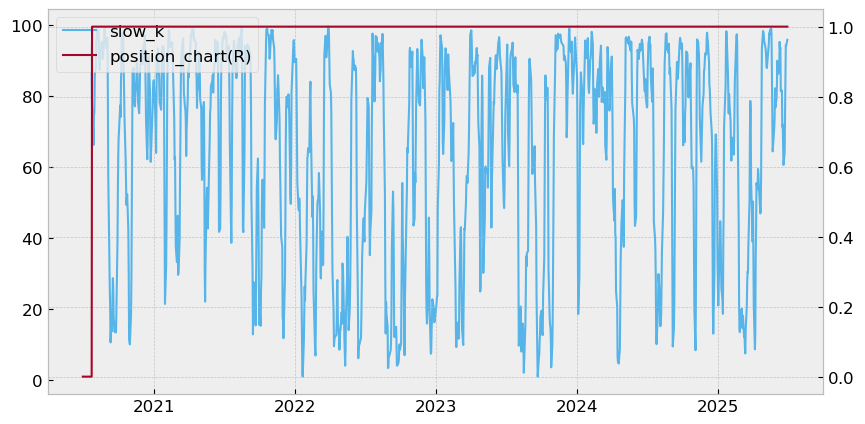

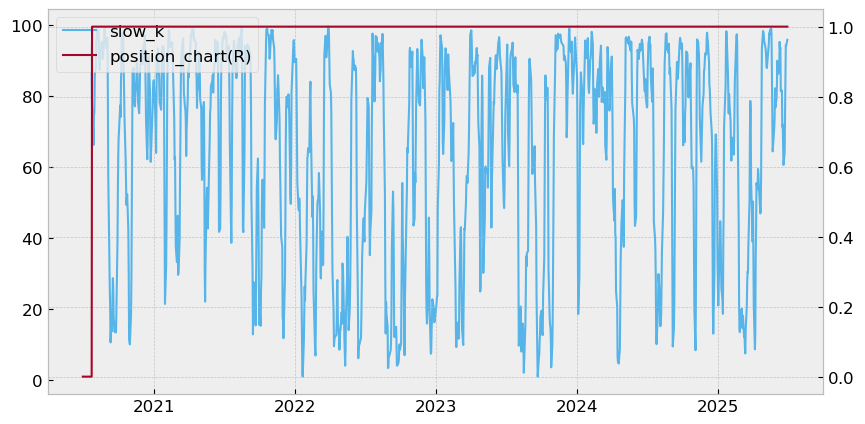

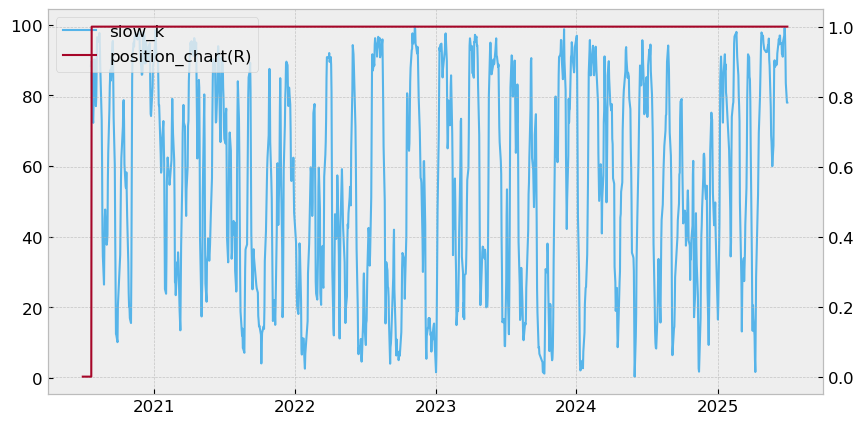

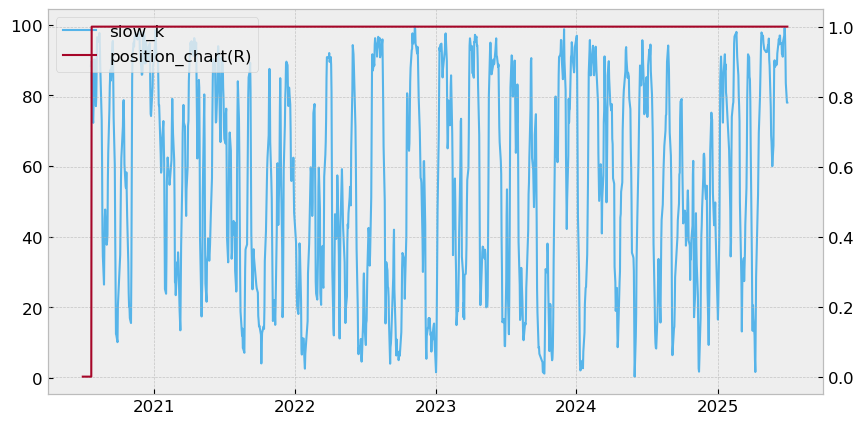

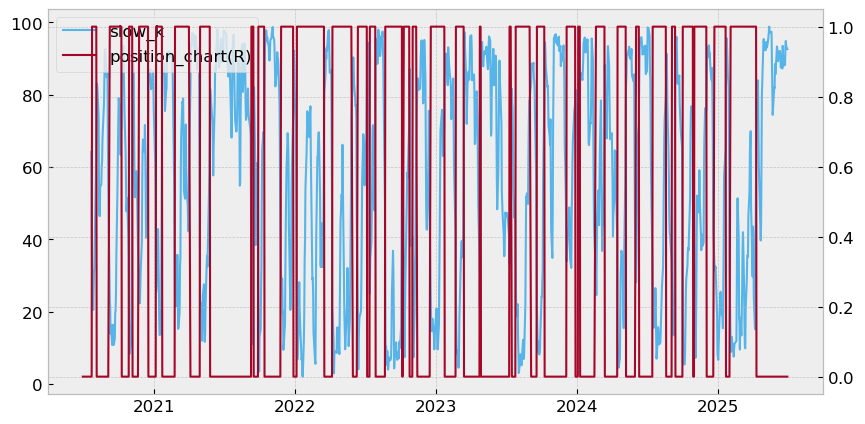

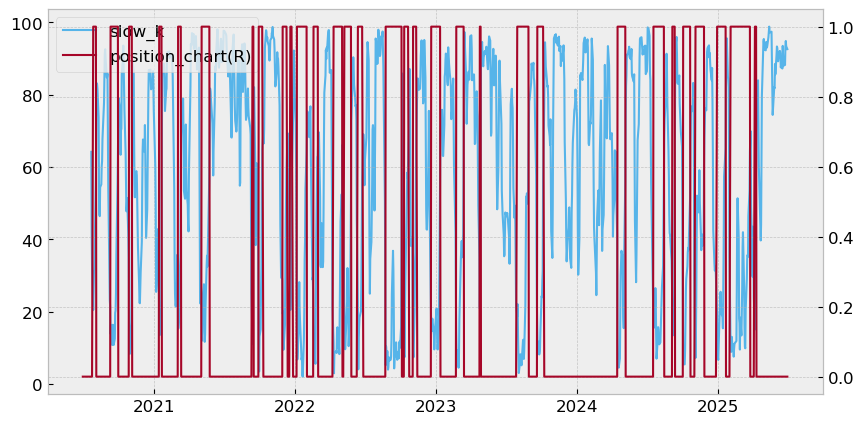

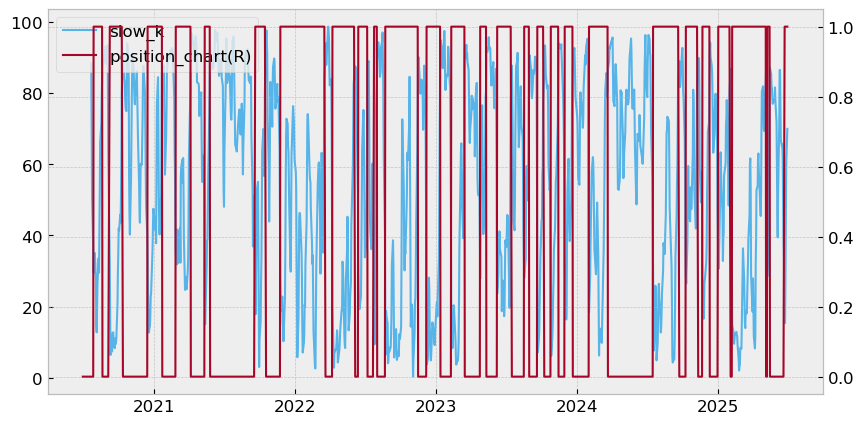

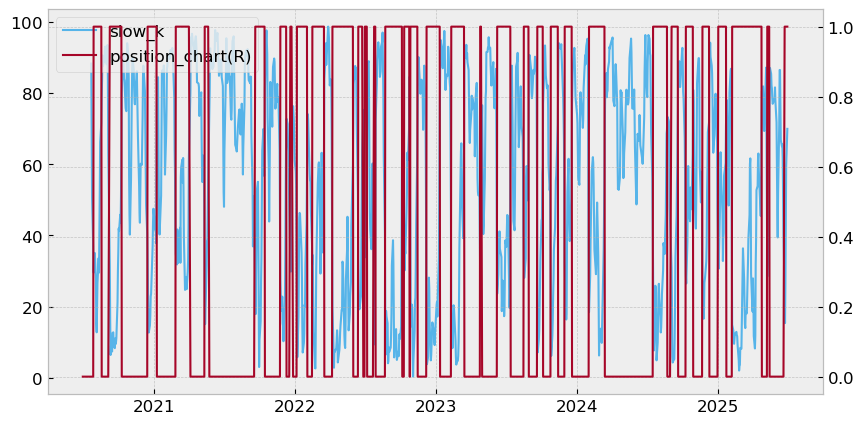

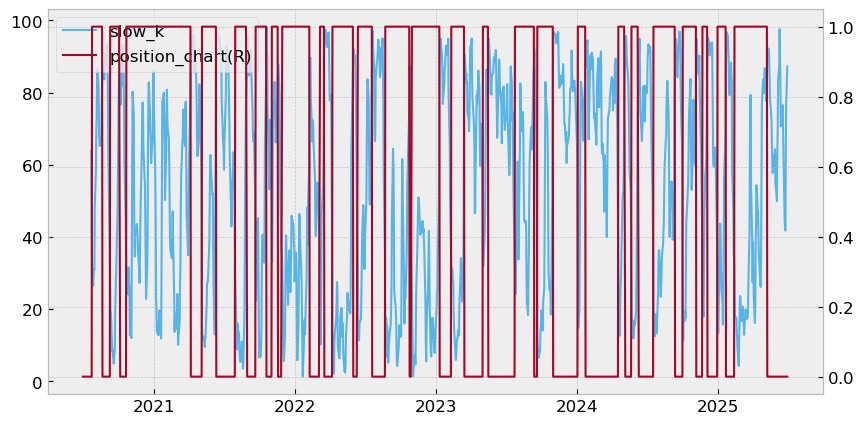

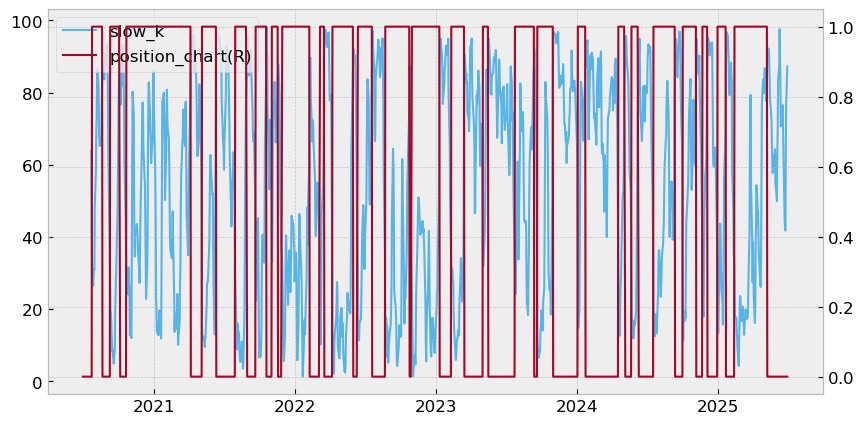

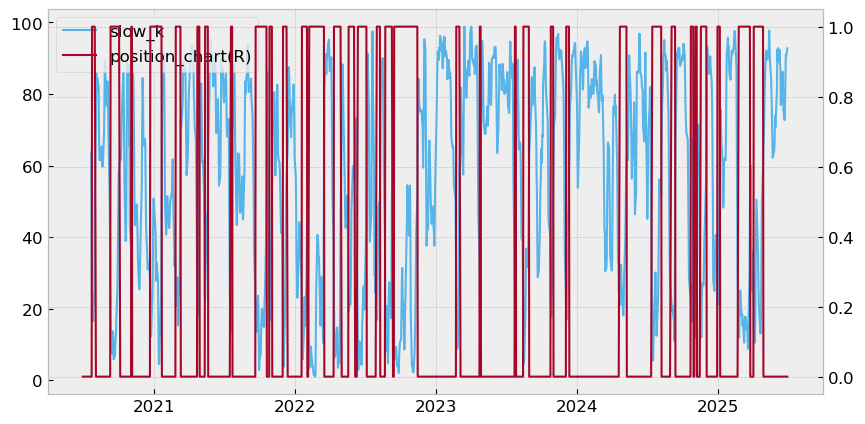

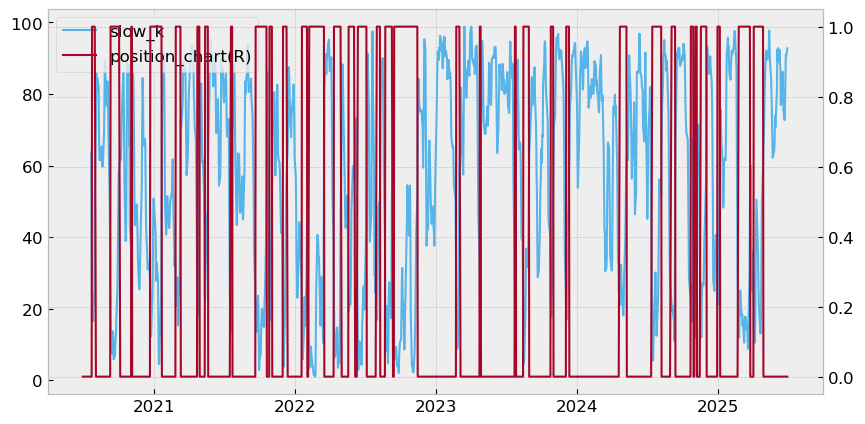

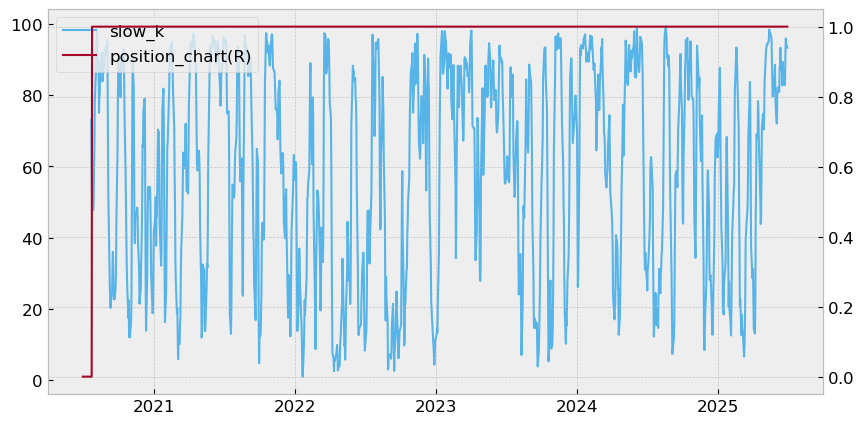

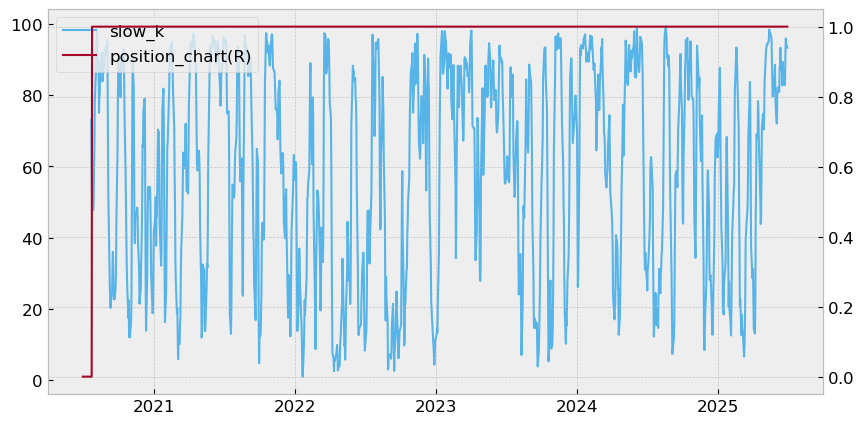

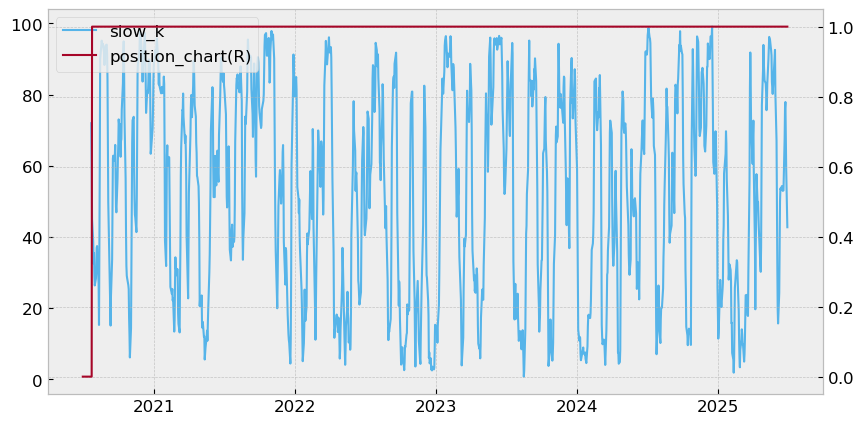

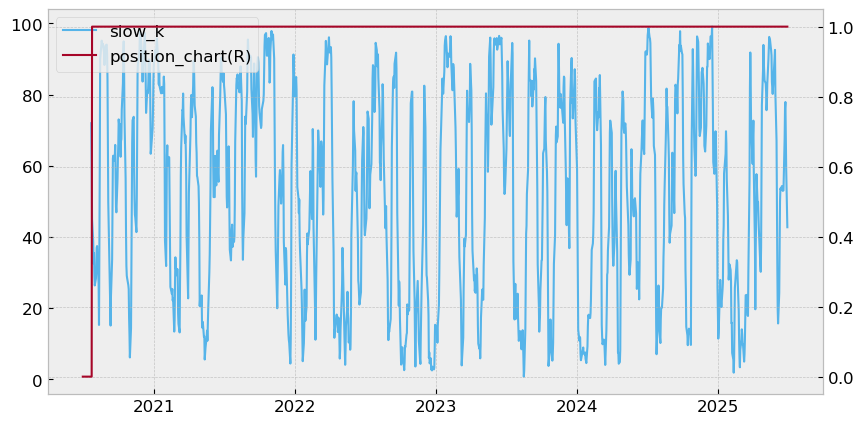

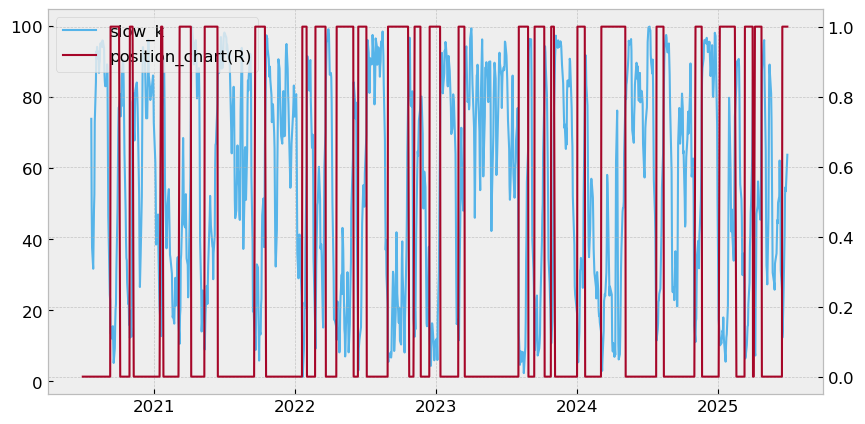

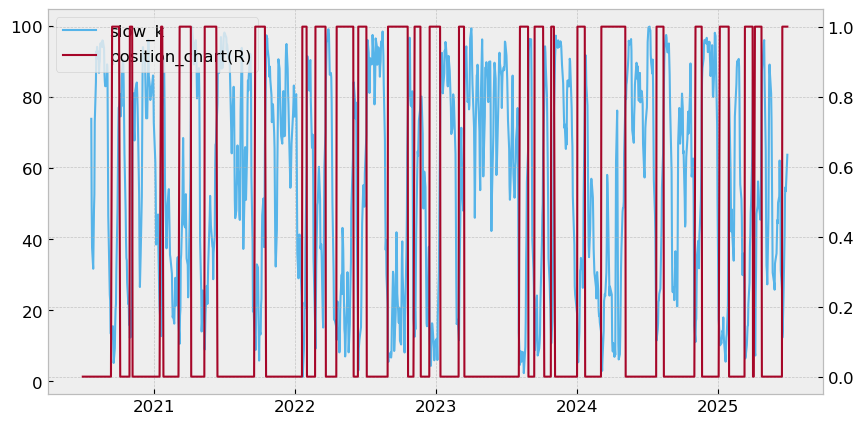

In [77]:
cols = ['CAGR','Sharpe ratio']
result_list = []

for symbol in symbol_list :
    for col in cols :
        series_rsi = get_rsi_max_performance(symbol, start_date_, end_date_, fee_, col)
        series_macd = get_macd_max_performance(symbol, start_date_, end_date_, fee_, col)
        series_sto = get_stochastic_max_performance(symbol, start_date_, end_date_, fee_, col)
        
        series_rsi.name = 'RSI'
        series_rsi['max_criteria']=col
        series_macd.name = 'MACD'
        series_macd['max_criteria']=col
        series_sto.name = 'Stochastic'
        series_sto['max_criteria']=col
        
        result_list.append(series_rsi)
        result_list.append(series_macd)
        result_list.append(series_sto)
        
result_list

In [80]:
df_result = pd.concat(result_list, axis=1).T
df_result

,symbol,w_param,buy_param,sell_param,fee_,CAGR,Accumulated return,Average return,Benchmark return,Number of trades,Number of win,Hit ratio,Investment period,Sharpe ratio,MDD,Benchmark MDD,max_criteria,factor
RSI,^GSPC,23,44,74,0.00,0.16,1.08,0.74,0.90,2.00,1.00,0.50,4.90,0.69,-0.25,-0.25,CAGR,NaN
MACD,^GSPC,NaN,-4,-4,0.00,0.12,0.74,0.03,1.00,14.00,7.00,0.50,5.00,0.68,-0.11,-0.25,CAGR,NaN
Stochastic,^GSPC,NaN,10,60,0.00,0.14,0.93,NaN,0.93,1.00,0.00,0.00,4.90,0.58,-0.25,-0.25,CAGR,indicator
RSI,^GSPC,7,22,77,0.00,0.15,1.03,0.08,0.97,9.00,8.00,0.89,5.00,0.84,-0.16,-0.25,Sharpe ratio,NaN
MACD,^GSPC,NaN,-4,-4,0.00,0.12,0.74,0.03,1.00,14.00,7.00,0.50,5.00,0.68,-0.11,-0.25,Sharpe ratio,NaN
Stochastic,^GSPC,NaN,10,60,0.00,0.14,0.93,NaN,0.93,1.00,0.00,0.00,4.90,0.58,-0.25,-0.25,Sharpe ratio,indicator
RSI,^KS11,9,22,56,0.00,0.12,0.77,0.04,0.44,14.00,13.00,0.93,5.00,0.97,-0.08,-0.35,CAGR,NaN
MACD,^KS11,NaN,8,7,0.00,0.09,0.52,0.02,0.47,18.00,10.00,0.56,5.00,0.52,-0.10,-0.35,CAGR,NaN
Stochastic,^KS11,NaN,10,60,0.00,0.07,0.39,NaN,0.39,1.00,0.00,0.00,4.90,0.23,-0.35,-0.35,CAGR,indicator
RSI,^KS11,9,22,55,0.00,0.12,0.77,0.04,0.44,14.00,13.00,0.93,5.00,0.99,-0.08,-0.35,Sharpe ratio,NaN


In [81]:
df_result[df_result.index == 'RSI']

,symbol,w_param,buy_param,sell_param,fee_,CAGR,Accumulated return,Average return,Benchmark return,Number of trades,Number of win,Hit ratio,Investment period,Sharpe ratio,MDD,Benchmark MDD,max_criteria,factor
RSI,^GSPC,23,44,74,0.00,0.16,1.08,0.74,0.90,2.00,1.00,0.50,4.90,0.69,-0.25,-0.25,CAGR,NaN
RSI,^GSPC,7,22,77,0.00,0.15,1.03,0.08,0.97,9.00,8.00,0.89,5.00,0.84,-0.16,-0.25,Sharpe ratio,NaN
RSI,^KS11,9,22,56,0.00,0.12,0.77,0.04,0.44,14.00,13.00,0.93,5.00,0.97,-0.08,-0.35,CAGR,NaN
RSI,^KS11,9,22,55,0.00,0.12,0.77,0.04,0.44,14.00,13.00,0.93,5.00,0.99,-0.08,-0.35,Sharpe ratio,NaN
RSI,MSFT,7,29,70,0.00,0.25,1.99,0.06,1.42,20.00,16.00,0.80,5.00,0.93,-0.25,-0.37,CAGR,NaN
RSI,MSFT,7,24,70,0.00,0.20,1.48,0.07,1.42,13.00,11.00,0.85,5.00,0.98,-0.15,-0.37,Sharpe ratio,NaN
RSI,GOOG,8,33,81,0.00,0.27,2.35,0.22,1.31,8.00,6.00,0.75,5.00,0.76,-0.45,-0.45,CAGR,NaN
RSI,GOOG,20,32,60,0.00,0.15,0.96,0.18,1.38,4.00,4.00,1.00,4.90,0.89,-0.15,-0.45,Sharpe ratio,NaN
RSI,AMZN,8,20,76,0.00,0.20,1.44,0.14,0.37,7.00,6.00,0.86,5.00,0.65,-0.22,-0.56,CAGR,NaN
RSI,AMZN,9,21,74,0.00,0.17,1.20,0.17,0.41,5.00,5.00,1.00,5.00,0.67,-0.19,-0.56,Sharpe ratio,NaN
